# Ptychography: extended Ptychographic Iterative Engine (ePIE) 


## Table of Contents <a name="toc"/>
[1. Introduction](#intro)<br>
[2. Methodology](#meth)<br>
[3. Preparation](#prep)<br>
[4. Read Data and Set Experimental Parameters ](#load)<br>
[5. Initialize probe and probe positions](#probe)<br>
[6. Set reconstruction parameters](#recon_param)<br> 
[7. Reconstruction](#recon)<br>
 * [a) First pass](#first)<br>
 * [b) Monitor the probe and object change](#plot)<br>
 * [c) Sample structure from ptychography: Compare to ADF](#compare)<br>
 
[8. What can go wrong?](#wrong_param)<br>
[9. Further improvements with more iterations and position refinement](#improve) <br>
[10. Higher resolution using multiple probe modes (optional)](#multiple) <br>

## 1. Introduction <a name="intro"/> 

Ptychography is a phase-contrast imaging technique and provides advantages in super-high resolution, high contrast and signal-to-noise, especially for samples containing elements with low atomic numbers or easily damaged during beam irradiation. Recently, a record resolution of 0.04 nm has been demonstrated, which is about 2.5 times better than conventional annular dark-field (ADF) images. The following images show the significant resolution improvement of ptychography (Ptycho) compared to ADF images from a twisted bilayer MoS$_2$ sample [Nature 559, 343 (2018)].

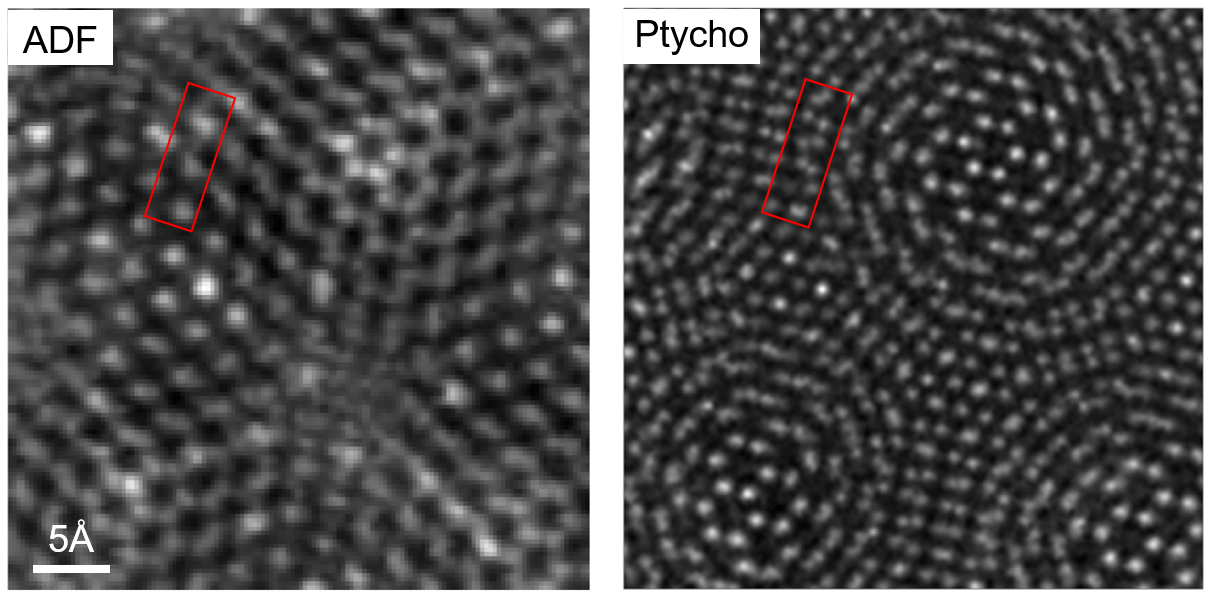

In this tutorial, we will learn how to do ptychography properly using the extended Ptychographic Iterative Engine (ePIE) approach [ref. Ultramicroscopy 109, 1256 (2009)]. In this approach, the sample structure (object function) and the probe shape can be iteratively reconstructed from 4D-STEM dataset. High frequency structural information can be retrieved from diffraction data with residual aberrations of the probe removed. Therefore, the spatial-resolution of the image is much higher than conventional STEM images. We will only consider thin samples such as 2D materials. For thicker samples, multiple scattering should be considered and the algorithm needs to be extended, reference to our recent paper [Z. Chen et al., Science 372, 826 (2021)].

[go to top](#toc)

## 2. Methodology <a name="meth"/> 

In thin samples, exit wave function [$\psi_{exit}(\vec r)$] can be calculated directly from the multiplication of the incident probe [$\psi_{probe}(\vec r)$] and the object (sample) transimission function [$O(\vec r)$], i.e., strong phase approximation. The measured diffraction patterns are the intensity of the exit wave in Fourier space.

$$
\psi_{exit}(\vec r) = \psi_{probe}(\vec r) \cdot O(\vec r)
$$

$$
I(k) = |FT[\psi_{exit}(\vec r)]|^{2}
$$

$$
O(\vec r) = A(\vec r) exp[i \sigma V(\vec r)]
$$

The phase of the object function is proportional to the electrostatic potential [$ V(\vec r)$] and contains the structural information of the sample.

ePIE uses an iterative approach, a simple flowchart shown below. It starts from an initial object and a probe. The initial object is usually generated with random numbers. The initial probe can be calculated from estimated aberration parameters. The intensity of the modelled diffraction patterns is modified iteratively to match that from the measured patterns. When the difference is sufficiently small, we can obtain the correct probe shape and the sample structure.

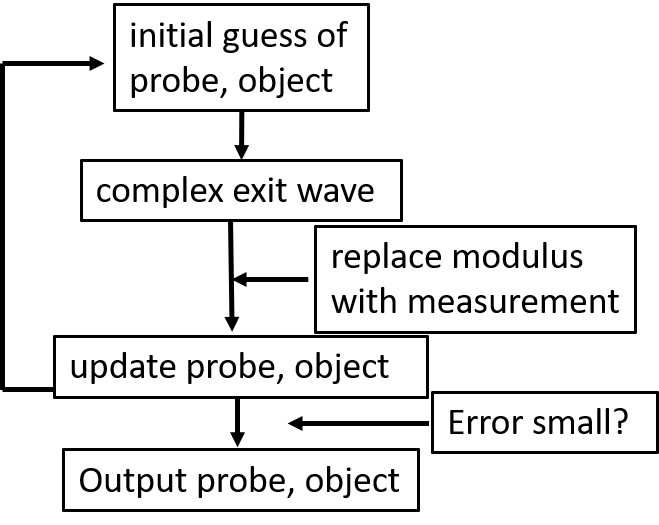

The central part of ePIE algorithm is the estimates of new probe and object function during each iteration. 

$$
O_{j+1}(\textbf{r}) = O_{j}(\textbf{r})+\alpha \frac{P_{j}^{*}(\textbf{r}-\textbf{R}_{s(j)})}{|P_{j}^{*}(\textbf{r}-\textbf{R}_{s(j)})|_{max}^{2}} (\psi_{j}^{'}(\textbf{r})-\psi_{j}(\textbf{r}))
$$

$$
P_{j+1}(\textbf{r}) = P_{j}(\textbf{r})+\beta \frac{O_{j}^{*}(\textbf{r}+\textbf{R}_{s(j)})}{|O_{j}^{*}(\textbf{r}+\textbf{R}_{s(j)})|_{max}^{2}} (\psi_{j}^{'}(\textbf{r})-\psi_{j}(\textbf{r}))
$$

The parameters $\alpha$ and $\beta$ control the update speed and can affect the quality of the results.

We will use a 4D-STEM data taken from a monolayer MoS$_2$ sample as an example. The sample data contains 31 × 26 diffraction patterns, and there is a single sulfur vacancy in the scanned region. A decent reconstruction needs 20 iterations, which takes about 1-2 minutes. We will use the demo ePIE code written in python. The main routines are put in ePIE_code/ptycho_recon folder. ptycho.py defines parameters and contains some pre-processing and pie_mixed_states.py does the main reconstruction.

### Think about the following questions and try to answer them after the tutorial:

<span style="color:red"> 1). How can we use all the pixels in the diffraction to get the real-space image? What is the difference between ptychography and ADF imaging?  </span> <br>

<span style="color:red"> 2). How does the probe shape look like? Is the probe aberration free after the aberration correction?   </span> <br>

<span style="color:red"> 3). What can we learn about the sample structure from ptychography?  </span> <br>


[go to top](#toc)

## 3. Preparation<a name="prep"/> 

<span style="color:orange"> Add the path to the folder ptycho_recon </span> which contains the functions for the 4D data processing and the ptychographic reconstruction in the command sys.path.append("__")

In [ ]:
# Importing necessary packages

import sys
sys.path.append("./ePIE_code/ptycho_recon") #add ptycho_recon path
import numpy as np
import os #for change directory
import scipy.io as sio #for read/write matlab file
import scipy.ndimage.filters as sfilter
import scipy.ndimage
#import scipy.misc
import matplotlib.pyplot as plt
%matplotlib notebook
import ptycho as pty
import utility_function as utils
import probe as probe
import postProcess as postProcess
import browser
#import h5py
from IPython.display import Video

from numpy import *
import time

[go to top](#toc)
## 4. Read Data and Set Experimental Parameters <a name="load"/>

1. Input the path to the 4D dataset here 
2. Set parameters for preprocessing and size of the diffraction patterns (default vaules, can be changed) 
3. Load or enter different experimental parameters (critical for proper reconstruction) 

In [ ]:
print("input data path and some data related parameters")

######################################### Parameters ##################################### 

data_name = 'MoS2_4D_data_step2x_crop_3x3uc.mat'
data_dir = '../Data/'
N_roi = 128 #Size of square diffraction patterns
rot_angle_d = 30 #(degree) Rotate the real space object instead of DP
#rot_angle_d = 0
result_dir_extra0 = 'test1'  # string for specific output folder name
ADU_background_cutoff = 20 #Threshold that below which would be removed
ADU_electronCount_ratio = 151.0 # factor needed to convert between detector output and actual electron counts 

##################################### read data ########################################
os.chdir(data_dir) #change to data directory
path = os.getcwd()
data = sio.loadmat(data_name)
print('variables loaded:')
print(data.keys())
      

The *.mat data file contains the 4D diffraction (dp), probe forming semi-angle (alpha_max), spherical aberration (cs), focus (df), pixel size in diffraction plane (dk), scan step size (scanStepSize_x/y), and beam voltage (voltage). 


In [ ]:
########################################################################################

dp = data['dp']*1.0 #4D Diffraction patterns

N_dp = dp.shape[0]

# parameters read from example *.mat file 
# if any of parameters to change, mannually input the corresponding variable

sx = 0 if not 'sx' in data else int(squeeze(data['sx'])) 
sy = 0 if not 'sy' in data else int(squeeze(data['sy']))
voltage = squeeze(data['voltage']) # kev
alpha_max = squeeze(data['alpha_max']) # mrad
df = squeeze(data['df']) # defocus (angstrom)
cs = squeeze(data['cs']) # spherical aberration (mm)
scanStepSize_x = squeeze(data['scanStepSize_x'])
scanStepSize_y = squeeze(data['scanStepSize_y'])

dk = squeeze(data['dk']) # reciprocal space pixel size (inverse angstrom)
print("dk =", dk)
dx = 1.0/dk/N_roi # real space pixel size (angstrom)
print("dx =", dx)

################################## data processing ##########################################
print("processing data")
result_dir_extra = "_preprocessCBED" #Directory name of output
dp, result_dir_extra = utils.transpose_cbed(dp, result_dir_extra) #Transpose scan direction x &y and update the directory name
#Set pixels that are less than threshold to 0 and update directory name
dp, result_dir_extra = utils.background_removal(dp, ADU_background_cutoff, result_dir_extra)

print("recon data size:", dp.shape)

Raw experimental data may need some pre-processing, such as matrix rotation or transpose or background removing. Related functions can be found in utility_function.py. 

### What does the 4D data look like?

In [ ]:
guis=browser.browser( np.transpose(dp, (2,3,0,1)) )

A short video to remind you of the experimental parameters and how the diffraction pattern looks as the beam is scanned over the sample.

In [ ]:
from IPython.display import HTML

HTML("""
<div align="middle">
<video width="80%" controls>
      <source src="../Data/pty_video.mp4" type="video/mp4">
</video></div>""")

[go to top](#toc)
## 5. Initialize probe and probe positions <a name="probe"/>
Before we start ptychography, we need an initial probe and define the coordinates of the probe positions.

In [ ]:
################################## make initial probe function ##################################
probe_init = probe.STEMprobe()
probe_init.df = df
probe_init.cs = cs
probe_init.alpha_max = alpha_max
probe_init.voltage = voltage

################################## calculate scan positions ####################################
#calculate scan positions
N_scan_y = dp.shape[2]
N_scan_x = dp.shape[3]

#Generate the arrays of the scanning positions after scanning rotation correction and update the info in the directory
ppX, ppY, result_dir_extra = utils.calculate_scan_positions(N_scan_x, N_scan_y, scanStepSize_x, scanStepSize_y, rot_angle_d, result_dir_extra)

Ny_max = max([abs(round(np.min(ppY)/dx)-floor(N_roi/2.0)), abs(round(np.max(ppY)/dx)+ceil(N_roi/2.0))])*2+1
Nx_max = max([abs(round(np.min(ppX)/dx)-floor(N_roi/2.0)), abs(round(np.max(ppX)/dx)+ceil(N_roi/2.0))])*2+1

#Extend the size of the object to accommondate position correction, and will crop later
N_image = int(max([Ny_max,Nx_max]))+20
print("Image size:", N_image)

### CHECKPOINT 1: 
   <span style="color:red"> 1). How to generate a STEM probe function? (Refer to session T1-Imaging) </span> <br> 

   <span style="color:red"> 2). How can we define the coordinates of probe positions? </span> <br> 

[go to top](#toc)
## 6. Set reconstruction parameters <a name="recon_param"/>
The major ptychography routine calls a class variable called reconObject. Parameters are input into paraDict. Some important parameters must be set. More default parameters can be found in ptycho.py.

In [ ]:
########################################### reconstruction #####################################
print('Set reconstruction parameters')
reconObject = pty.ptycho(dp, dk, probe_init, ppX, ppY)
reconObject.paraDict['dk_y'] = dk
reconObject.paraDict['dk_x'] = dk
reconObject.paraDict['N_image'] = N_image 
reconObject.paraDict['N_roi'] = N_roi #Size of ROI
reconObject.paraDict['Niter'] = 20 #Number of iterations
reconObject.paraDict['Niter_update_probe'] = 0 #Update probe from the 1st iteration
reconObject.paraDict['Niter_save'] = 5 #How often to save the reconstruction results

reconObject.paraDict['beta'] = 1 #Learning rate for updating probe
reconObject.paraDict['alpha'] = 0.1 #Learning rate for updating object

reconObject.paraDict['rotationAngle']  = rot_angle_d

reconObject.paraDict['printID'] = 'MoS2' #sample label

### CHECKPOINT 2:

<span style="color:red"> Do you have any questions about the 4 dimensional dataset or the different experimental and reconstruction parameters? </span> <br> 

[go to top](#toc)
## 7. Reconstruction <a name="recon"/>

### a). First pass <a name="first"/>

In [ ]:
################################################################
result_dir = data_dir + "/mos2_" + result_dir_extra0
result_dir_extra = reconObject.initialize(result_dir) #Load the predefined parameters

#print(reconObject.paraDict['saveName'])
start_time = time.time()
reconObject.recon() #start reconstruction
total_time = time.time() - start_time

timeLeftMin, timeLeftSec = divmod(total_time, 60)
timeLeftHour, timeLeftMin = divmod(timeLeftMin, 60)
print('Total recon time: %02d:%02d:%02d' %(timeLeftHour,timeLeftMin,timeLeftSec))


### CHECKPOINT 3: <span style="color:red"> What can we get? </span> <br> 
1. Find the path of the saved results
2. Let's do some plotting

[go to top](#toc)
### b) Monitor the probe and object change <a name="plot"/>
 check how to generate correct probe and object from blank/ideal ones

In [ ]:
os.chdir(path)
#### one example for plots ###
Niters=[5,10,15,20]  # read in results from some iterations
fig2, ax2 = plt.subplots(nrows=2, ncols=len(Niters))
plt.figure(1)
for kk in range(len(Niters)):
    prev_recon_name = "./mos2_" + result_dir_extra0 + "/" + "recon_Niter" + str(Niters[kk]) + ".mat"
    prev_recon_data = sio.loadmat(prev_recon_name)
    print(prev_recon_name)
    obj=prev_recon_data['object']
    prb=prev_recon_data['probes']
    px = prev_recon_data['ppX']
    py = prev_recon_data['ppY']
    dx = prev_recon_data['dx_x']
    obj_crop = postProcess.postProcess(obj, rot_angle_d, px, py, dx)
    ax2[0,kk].imshow( np.angle(obj_crop) )
    ax2[0,kk].set_title('Object Iter #' + str(Niters[kk]) )   
    for jj in range(prb.shape[0]):
        ax2[jj+1,kk].imshow( np.abs(prb[jj,:,:]) )
        if prb.shape[0] == 1 :
            title_str='Probe Iter #' + str(Niters[kk])
        else:                
            title_str='Probe Mode #' + str(jj+1)
        ax2[jj+1,kk].set_title(title_str) 
        

### <span style="color:red"> CHECKPOINT 4: Probe shape? </span> <br> 

[go to top](#toc)
### c) . Sample structure from ptychography: Compare to ADF  <a name="compare"/>


In [ ]:
N_iter = 20
prev_recon_name = data_dir + "/mos2_" + result_dir_extra0 + "/" +  "recon_Niter" + str(N_iter) + ".mat"
prev_recon_data = sio.loadmat(prev_recon_name)
print(prev_recon_name)
obj = prev_recon_data['object']
px = prev_recon_data['ppX']
py = prev_recon_data['ppY']
dx = prev_recon_data['dx_x']
obj_crop = postProcess.postProcess(obj, rot_angle_d, px, py, dx)

pty_y=np.zeros((3,43))

pty_y[0,:] = np.angle(obj_crop[0:43,21])
pty_y[1,:] = np.angle(obj_crop[0:43,22])
pty_y[2,:] = np.angle(obj_crop[0:43,23])
pty_m = pty_y.mean(axis=0)
pty_m = ( pty_m - pty_m.min() ) / ( pty_m.max() - pty_m.min() )

#obj_crop = postProcess(obj, rot_angle_d, px, py, dx)
ADF = plt.imread(data_dir + "/MoS2_ADF.png")
ADF_y=np.zeros((3,27))
ADF_y[0,:] = ADF[0:27,11]
ADF_y[1,:] = ADF[0:27,12]
ADF_y[2,:] = ADF[0:27,13]
ADF_m = ADF_y.mean(axis=0)
ADF_m = ( ADF_m - ADF_m.min() ) / ( ADF_m.max() - ADF_m.min() )

fig0, ax0 = plt.subplots(nrows=2, ncols=2)
fig0.tight_layout()
ax0[0,0].imshow(ADF)
ax0[0,0].set_title('ADF')   
ax0[1,0].plot(range(27),ADF_m)
ax0[1,0].set_title('ADF lineprofile')   
ax0[0,1].imshow(np.angle(obj_crop) )
ax0[0,1].set_title('Ptychography Iter #' + str(N_iter) )   
ax0[1,1].plot(range(43),pty_m)
ax0[1,1].set_title('Pty lineprofile Iter #' + str(N_iter))   

### CHECKPOINT 5: <span style="color:red"> What can we learn? </span> <br> 

[go to top](#toc)

## 8. What can go wrong?  <a name="wrong_param"/> 

Since there are quite a lot experimental and reconstruction parameters, using correct parameters is critical for a correct/good reconstruction. Here are two examples from wrong parameters. We only plot the reconstructions to save time but you can modify the parameters above to do the reconstructions.

### a). When rotation angle is wrong, the reconstruction result is as follows:

Rotation is 0 instead of 30 degrees.

In [ ]:
Niters=[1,5,10,20]  # read in results from some iterations
fig2, ax2 = plt.subplots(nrows=2, ncols=len(Niters))
for kk in range(len(Niters)):
    prev_recon_name = data_dir + "/mos2_" + "wrong_rotate0" + "/" + "recon_Niter" + str(Niters[kk]) + ".mat"
    prev_recon_data = sio.loadmat(prev_recon_name)
    print(prev_recon_name)
    obj=prev_recon_data['object']
    prb=prev_recon_data['probes']
    px = prev_recon_data['ppX']
    py = prev_recon_data['ppY']
    dx = prev_recon_data['dx_x']
    obj_crop = postProcess.postProcess(obj, 0, px, py, dx)
    ax2[0,kk].imshow( np.angle(obj_crop) )
    ax2[0,kk].set_title('Object Iter #' + str(Niters[kk]) )   
    ax2[1,kk].imshow( np.abs(prb[0,:,:]) )
    title_str='Probe Iter #' + str(Niters[kk])
    ax2[1,kk].set_title(title_str) 
        

### CHECKPOINT 6: 
<span style="color:red"> Why does wrong rotation angle degrade the reconstruction result?

### b). When dk is wrong:
Here the value of dk used is 50% of the actual value.

In [ ]:
Niters=[1,5,10,20]  # read in results from some iterations
fig2, ax2 = plt.subplots(nrows=2, ncols=len(Niters))
for kk in range(len(Niters)):
    prev_recon_name = data_dir + "/mos2_" + "wrong_0p5dk" + "/" + "recon_Niter" + str(Niters[kk]) + ".mat"
    prev_recon_data = sio.loadmat(prev_recon_name)
    print(prev_recon_name)
    obj=prev_recon_data['object']
    prb=prev_recon_data['probes']
    px = prev_recon_data['ppX']
    py = prev_recon_data['ppY']
    dx = prev_recon_data['dx_x']
    obj_crop = postProcess.postProcess(obj, 30, px, py, dx)
    ax2[0,kk].imshow( np.angle(obj_crop) )
    ax2[0,kk].set_title('Object Iter #' + str(Niters[kk]) )   
    ax2[1,kk].imshow( np.abs(prb[0,:,:]) )
    title_str='Probe Iter #' + str(Niters[kk])
    ax2[1,kk].set_title(title_str) 
        

<span style="color:red"> Why does wrong dk degrade the reonstruction result?

### CHECKPOINT 7

We have now seen how to do basic reconstructions with a few iterations. We also saw how wrong values of parameters can completely ruin the reconstruction quality. Before we move onto ways in which we can further improve the reconstruction quality, are there any questions about the iterative algorithm?

[go to top](#toc)
## 9. Further improvements with more iterations and position refinement <a name="improve"/>
<span style="color:red"> If you have changed parameters in the previous session, you will need to restore the correct ones. </span><br>

Keep in mind that the original correct parameters are stored in data (*.mat) file.

In [ ]:
## Let's restore the correct parameters from data

alpha_max = squeeze(data['alpha_max']) # mrad
scanStepSize_x = squeeze(data['scanStepSize_x'])
scanStepSize_y = squeeze(data['scanStepSize_y'])
probe_init.alpha_max = alpha_max

N_roi = 128 #Size of square diffraction patterns

dk = squeeze(data['dk']) # reciprocal space pixel size (inverse angstrom)
dx = 1.0/dk/N_roi # real space pixel size (angstrom)
ppX, ppY, result_dir_extra = utils.calculate_scan_positions(N_scan_x, N_scan_y, scanStepSize_x, scanStepSize_y, rot_angle_d, result_dir_extra)

Ny_max = max([abs(round(np.min(ppY)/dx)-floor(N_roi/2.0)), abs(round(np.max(ppY)/dx)+ceil(N_roi/2.0))])*2+1
Nx_max = max([abs(round(np.min(ppX)/dx)-floor(N_roi/2.0)), abs(round(np.max(ppX)/dx)+ceil(N_roi/2.0))])*2+1

#Extend the size of the object to accommondate position correction, and will crop later
N_image = int(max([Ny_max,Nx_max]))+20


reconObject = pty.ptycho(dp, dk, probe_init, ppX, ppY)
reconObject.paraDict['dk_y'] = dk
reconObject.paraDict['dk_x'] = dk
reconObject.paraDict['N_image'] = N_image 
reconObject.paraDict['N_roi'] = N_roi #Size of ROI
reconObject.paraDict['Niter'] = 20 #Number of iterations
reconObject.paraDict['Niter_update_probe'] = 0 #Update probe from the 1st iteration
reconObject.paraDict['Niter_save'] = 5 #How often to save the reconstruction results

reconObject.paraDict['beta'] = 1 #Learning rate for updating probe
reconObject.paraDict['alpha'] = 0.1 #Learning rate for updating object

reconObject.paraDict['rotationAngle']  = rot_angle_d

We can use a previous run as a better initial guess to help get the convergent solution.

Let's grab the path of a good previous run first and load the probes and object as the initial start.

In [ ]:
result_dir_extra_opt = 'optimization'

############## load existing probe and object ##############

prev_recon_name = data_dir + "/mos2_" + result_dir_extra0 + "/" + "recon_Niter20.mat"
print(prev_recon_name)

prev_recon_data = sio.loadmat(prev_recon_name)
reconObject.paraDict['probes0'] = prev_recon_data['probes'] #mixed states opr\n",
reconObject.paraDict['previous_obj'] = prev_recon_data['object'] #mixed states opr\n",

We can use more iterations and better sampling to improve the reconstruction. But it needs more time!

In [ ]:
reconObject.paraDict['Niter'] = 40 #Number of iterations
reconObject.paraDict['Niter_save'] = 10 #How often to save the reconstruction results
############## position correction ##############
reconObject.paraDict['Niter_update_position'] = 10 #Since which iteration to update positions

result_dir = data_dir + "/mos2_" + result_dir_extra0 + '_' + result_dir_extra_opt
result_dir_extra = reconObject.initialize(result_dir) #Load the predefined parameters

print(reconObject.paraDict['saveName'])
start_time = time.time()
reconObject.recon() #start reconstruction
total_time = time.time() - start_time

timeLeftMin, timeLeftSec = divmod(total_time, 60)
timeLeftHour, timeLeftMin = divmod(timeLeftMin, 60)
print('Total recon time: %02d:%02d:%02d' %(timeLeftHour,timeLeftMin,timeLeftSec))

Let's plot the results and compare with the previous results.

In [ ]:
os.chdir(path)
prev_recon_name = data_dir + "/mos2_" + result_dir_extra0+ "_" + result_dir_extra_opt + "/" +  "recon_Niter40" + ".mat"
prev_recon_data = sio.loadmat(prev_recon_name)
print(prev_recon_name)
obj = prev_recon_data['object']
probe = prev_recon_data['probes']
px = prev_recon_data['ppX']
py = prev_recon_data['ppY']
dx = prev_recon_data['dx_x']
print(np.shape(obj))
print("dx=",dx)
print(rot_angle_d)
obj_crop = postProcess.postProcess(obj, rot_angle_d, px, py, dx)

print(np.shape(obj_crop))
fig0, ax0 = plt.subplots(nrows=1, ncols=3)
fig0.tight_layout()
ax0[0].imshow(np.abs(obj_crop))
ax0[0].set_title('Amplitude')      
ax0[1].imshow(np.angle(obj_crop) )
ax0[1].set_title('Phase')   
ax0[2].imshow(np.abs(probe[0,:,:]))
ax0[2].set_title('Probe')      
  

### CHECKPOINT 8:
<span style="color:red"> We have now run more iterations and included position refinements. Do you see improvments?

[go to top](#toc)
## 10. Higher resolution using multiple probe modes (optional) <a name="multiple"/>
Electron probe is not a perfect coherent probe. The partial coherence can be modeled by using multiple probe modes, i.e., a mixed-state probe.

In [ ]:
############## mixed-states recon ############## (something might be wrong)
## Let's restore the correct parameters from data

alpha_max = squeeze(data['alpha_max']) # mrad
scanStepSize_x = squeeze(data['scanStepSize_x'])
scanStepSize_y = squeeze(data['scanStepSize_y'])
probe_init.alpha_max = alpha_max

N_roi = 128 #Size of square diffraction patterns

dk = squeeze(data['dk']) # reciprocal space pixel size (inverse angstrom)
dx = 1.0/dk/N_roi # real space pixel size (angstrom)
ppX, ppY, result_dir_extra = utils.calculate_scan_positions(N_scan_x, N_scan_y, scanStepSize_x, scanStepSize_y, rot_angle_d, result_dir_extra)

Ny_max = max([abs(round(np.min(ppY)/dx)-floor(N_roi/2.0)), abs(round(np.max(ppY)/dx)+ceil(N_roi/2.0))])*2+1
Nx_max = max([abs(round(np.min(ppX)/dx)-floor(N_roi/2.0)), abs(round(np.max(ppX)/dx)+ceil(N_roi/2.0))])*2+1

#Extend the size of the object to accommondate position correction, and will crop later
N_image = int(max([Ny_max,Nx_max]))+20


reconObject = pty.ptycho(dp, dk, probe_init, ppX, ppY)
reconObject.paraDict['dk_y'] = dk
reconObject.paraDict['dk_x'] = dk
reconObject.paraDict['N_image'] = N_image 
reconObject.paraDict['N_roi'] = N_roi #Size of ROI
reconObject.paraDict['Niter'] = 20 #Number of iterations
reconObject.paraDict['Niter_update_probe'] = 0 #Update probe from the 1st iteration
reconObject.paraDict['Niter_save'] = 5 #How often to save the reconstruction results

reconObject.paraDict['beta'] = 1 #Learning rate for updating probe
reconObject.paraDict['alpha'] = 0.1 #Learning rate for updating object

reconObject.paraDict['rotationAngle']  = rot_angle_d

########################################################

os.chdir(path)
reconObject.paraDict['N_probe'] = 3 #number of probes
reconObject.paraDict['N_object'] = 1 #default = 1
#reconObject.paraDict['Niter_update_states'] = 50
reconObject.paraDict['Niter_update_states'] = 0 #Since which iteration to do mixed-state update

result_dir_extra_mixed = 'mixed_state'

print("probe modes:",reconObject.paraDict['N_probe'])

############## load existing probe and object ##############

prev_recon_name = data_dir + "/mos2_" + result_dir_extra0 + "_" + result_dir_extra_opt + "/" + "recon_Niter40" + ".mat"
print(prev_recon_name)
prev_recon_data = sio.loadmat(prev_recon_name)
#reconObject.paraDict['previous_probe'] = prev_recon_data['probes'] #mixed states opr\n",
#reconObject.paraDict['previous_obj'] = prev_recon_data['object'] #mixed states opr\n",
reconObject.paraDict['Niter'] = 40 #Number of iterations
reconObject.paraDict['Niter_save'] = 10 #How often to save the reconstruction results
############## position correction ##############
reconObject.paraDict['Niter_update_position'] = 40 #Since which iteration to update positions

result_dir = data_dir + "/mos2_" + result_dir_extra0 + '_' + result_dir_extra_mixed
result_dir_extra = reconObject.initialize(result_dir) #Load the predefined parameters

#print(reconObject.paraDict['saveName'])
start_time = time.time()
reconObject.recon() #start reconstruction
total_time = time.time() - start_time

timeLeftMin, timeLeftSec = divmod(total_time, 60)
timeLeftHour, timeLeftMin = divmod(timeLeftMin, 60)
print('Total recon time: %02d:%02d:%02d' %(timeLeftHour,timeLeftMin,timeLeftSec))

Please create your own code to plot the probe modes and object function. Now there are more than one probe modes, you can check the size/dimension of the probes.


In [ ]:
os.chdir(path)
#### plotting ...
prev_recon_name = data_dir + "/mos2_" + result_dir_extra0+ "_" + result_dir_extra_mixed + "/" +  "recon_Niter40" + ".mat"
prev_recon_data = sio.loadmat(prev_recon_name)
print(prev_recon_name)
obj = prev_recon_data['object']
probe = prev_recon_data['probes']
px = prev_recon_data['ppX']
py = prev_recon_data['ppY']
dx = prev_recon_data['dx_x']
print(np.shape(obj))
print("dx=",dx)
print(rot_angle_d)
obj_crop = postProcess.postProcess(obj, rot_angle_d, px, py, dx)

print(np.shape(obj_crop))
print(probe.shape[0])
fig0, ax0 = plt.subplots(nrows=1, ncols=probe.shape[0])
fig0.tight_layout()
for jj in range(probe.shape[0]):
    ax0[jj].imshow(np.abs(probe[jj,:,:]))
    ax0[jj].set_title('Mode #' + str(jj+1) ) 
    
fig1, ax1 = plt.subplots(nrows=1, ncols=2)
fig1.tight_layout()
ax1[0].imshow(np.abs(obj_crop))
ax1[0].set_title('Amplitude')      
ax1[1].imshow(np.angle(obj_crop) )
ax1[1].set_title('Phase') 

[go to top](#toc)